In [1]:
import pandas as pd
import numpy as np

In [2]:
data_path = '/Users/graceliu/Desktop/Columbia/Spring 2025/NLP/final_project/coinbase_reviews_cleaned.csv'
coinbase_df = pd.read_csv(data_path)
coinbase_df.head()

,date,developerResponse,review,rating,isEdited,userName,title,ml_rating
0,2021-10-11 01:28:16,"{'id': 25674719, 'body': 'Hi there, thank you ...",impressed easy app use endless amounts informa...,5,False,dank0116,Easy money !,5
1,2025-01-23 03:06:29,"{'id': 49919909, 'body': 'Hi there, Stevenra14...",really good app crypto beginners intermediate ...,4,False,Stevenra14,"Great app, but missing a few key things…",4
2,2024-10-22 02:53:25,"{'id': 47669014, 'body': ""Hello Robinhoodallda...",use coinbase three years happy service halfway...,1,False,Robinhoodallday,Used for years but has gone to crap,1
3,2024-11-11 20:08:17,"{'id': 48168788, 'body': ""Hi CPG Tiberius, we'...",absolutely mind boggling unhelpful circular cu...,1,False,CPG Tiberius,Worst Customer Support,1
4,2025-04-12 14:35:28,"{'id': 51660061, 'body': ""Hi Usjnendin, we’re ...",left coinbase years ago kept removing payment ...,1,True,Usjnendin,Holding Money Hostage,1


# Sentiment Analysis (vader)
### good for short texts and detecting polarity

In [3]:
!pip install vaderSentiment

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [4]:
coinbase_df['vader_scores'] = coinbase_df['review'].apply(analyzer.polarity_scores)
coinbase_df[['vader_neg', 'vader_neu', 'vader_pos', 'vader_compound']] = coinbase_df['vader_scores'].apply(pd.Series)

In [5]:
def label_vader_sentiment(compound_score):
    if compound_score > 0.963:
        return "positive"
    else:
        return "negative"
    # elif compound_score < 0.8:
    #     return "negative"
    # else:
    #     return "neutral"

coinbase_df['vader_sentiment'] = coinbase_df['vader_compound'].apply(label_vader_sentiment)
coinbase_df.head()

,date,developerResponse,review,rating,isEdited,userName,title,ml_rating,vader_scores,vader_neg,vader_neu,vader_pos,vader_compound,vader_sentiment
0,2021-10-11 01:28:16,"{'id': 25674719, 'body': 'Hi there, thank you ...",impressed easy app use endless amounts informa...,5,False,dank0116,Easy money !,5,"{'neg': 0.063, 'neu': 0.662, 'pos': 0.275, 'co...",0.063,0.662,0.275,0.9717,positive
1,2025-01-23 03:06:29,"{'id': 49919909, 'body': 'Hi there, Stevenra14...",really good app crypto beginners intermediate ...,4,False,Stevenra14,"Great app, but missing a few key things…",4,"{'neg': 0.059, 'neu': 0.635, 'pos': 0.306, 'co...",0.059,0.635,0.306,0.9888,positive
2,2024-10-22 02:53:25,"{'id': 47669014, 'body': ""Hello Robinhoodallda...",use coinbase three years happy service halfway...,1,False,Robinhoodallday,Used for years but has gone to crap,1,"{'neg': 0.057, 'neu': 0.764, 'pos': 0.179, 'co...",0.057,0.764,0.179,0.9517,negative
3,2024-11-11 20:08:17,"{'id': 48168788, 'body': ""Hi CPG Tiberius, we'...",absolutely mind boggling unhelpful circular cu...,1,False,CPG Tiberius,Worst Customer Support,1,"{'neg': 0.074, 'neu': 0.736, 'pos': 0.19, 'com...",0.074,0.736,0.190,0.8542,negative
4,2025-04-12 14:35:28,"{'id': 51660061, 'body': ""Hi Usjnendin, we’re ...",left coinbase years ago kept removing payment ...,1,True,Usjnendin,Holding Money Hostage,1,"{'neg': 0.026, 'neu': 0.767, 'pos': 0.207, 'co...",0.026,0.767,0.207,0.9778,positive


In [6]:
coinbase_df['vader_sentiment'].value_counts()

vader_sentiment
negative    866
positive    134
Name: count, dtype: int64

## tf-idf in negative reviews

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_tfidf(df, text_col, min_n=1, max_n=1):
    vectorizer = TfidfVectorizer(ngram_range=(min_n, max_n), stop_words = 'english')

    # Fit and transform the review text
    tfidf_matrix = vectorizer.fit_transform(df[text_col])

    # Create DataFrame with feature names
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    return tfidf_df

In [8]:
neg_reviews = coinbase_df[coinbase_df['vader_sentiment'] == 'negative'].copy()
tfidf_neg = compute_tfidf(neg_reviews, 'review')

neg_rare_words = tfidf_neg.mean().sort_values().head(15)
neg_rare_words.columns = ['word', 'avg_tfidf']
print(neg_rare_words)

parameters     0.000101
permanent      0.000101
dialogue       0.000101
south          0.000113
machine        0.000113
replay         0.000113
border         0.000113
ca             0.000113
korean         0.000113
acted          0.000113
shift          0.000113
neglect        0.000119
tender         0.000119
excessively    0.000119
convenience    0.000119
dtype: float64


### doesn't tell us much

In [9]:
# recurring themes (most common words in neg reviews)
from collections import Counter

all_words = " ".join(neg_reviews['review']).split()
word_counts = Counter(all_words)
common_neg_words = pd.DataFrame(word_counts.most_common(20), columns=['word', 'count'])
common_neg_words

,word,count
0,coinbase,1294
1,account,1085
2,app,975
3,money,871
4,crypto,590
5,get,542
6,support,423
7,customer,409
8,bank,390
9,even,386


### customer support/service, fees are pain points. "time" so also maybe how long the app takes to transfer funds, etc.

# Topic Modeling (LDA)

## LDA using gensim (USE THIS, not sklearn)

In [10]:
!pip install gensim
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

In [11]:
# 1. Tokenize and preprocess
texts = [simple_preprocess(doc, deacc=True) for doc in neg_reviews['review']]

# 2. Create dictionary and bag-of-words corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# 3. Train LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=4,
                     random_state=42,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

# 4. Print top words per topic
for i, topic in lda_model.show_topics(num_topics=4, formatted=False):
    print(f"Topic {i+1}: {[word for word, _ in topic]}")

Topic 1: ['money', 'account', 'coinbase', 'bank', 'app', 'fees', 'back', 'get', 'buy', 'bitcoin']
Topic 2: ['app', 'crypto', 'coinbase', 'like', 'even', 'see', 'one', 'coin', 'use', 'time']
Topic 3: ['coinbase', 'app', 'crypto', 'money', 'buy', 'time', 'get', 'fees', 'would', 'use']
Topic 4: ['account', 'coinbase', 'money', 'customer', 'support', 'app', 'get', 'service', 'email', 'crypto']


### Insights
1. customer support (also phone, email, number, access) --> complaints about not reaching customer support --> improve customer support and communication
2. account, money --> frustration around accessing account/money --> streamline account recovery process
3. fees --> unclear or high fees --> improve fee transparency
4. time --> bad timing of transactions or delays --> improve reliabliity and speed of banking/crypto transfers

In [12]:
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=16098) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=16098) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=16098) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=16098) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarnin

In [13]:
!pip install wordcloud matplotlib
from wordcloud import WordCloud
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.12/pty.py:95: DeprecationWarning: This process (pid=16098) is multi-threaded, use of forkpty() may lead to deadlocks in the child.
  pid, fd = os.forkpty()


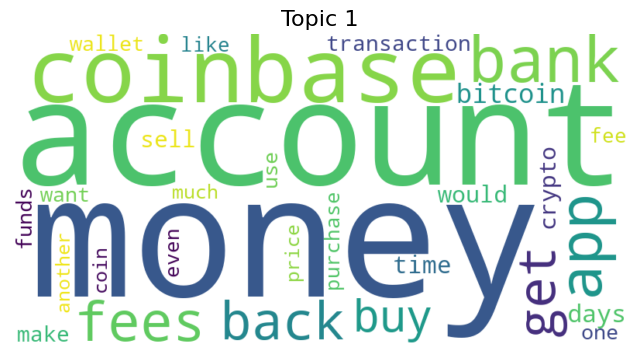

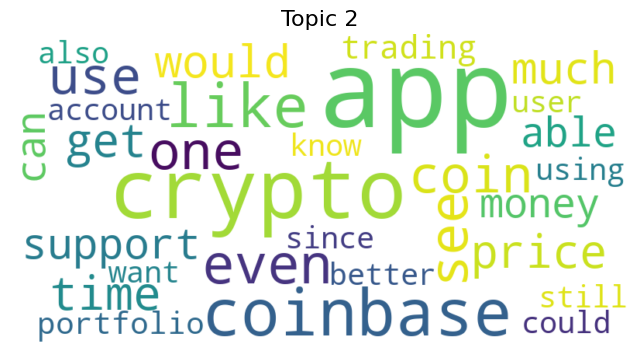

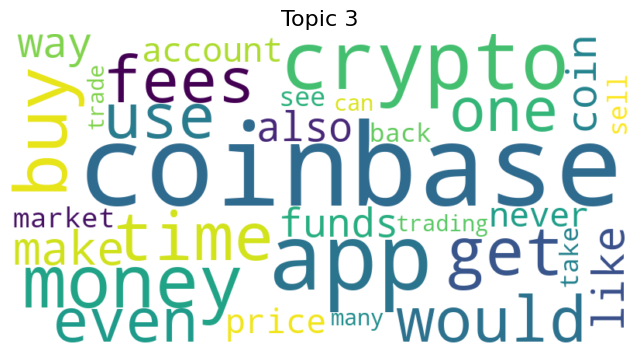

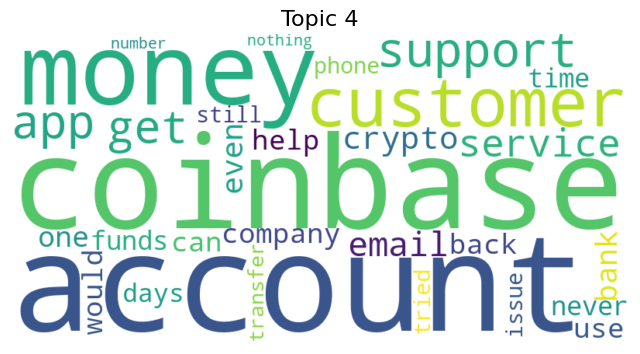

In [14]:
for i in range(lda_model.num_topics):
    plt.figure(figsize=(8, 6))
    plt.title(f"Topic {i + 1}", fontsize=16)
    
    # Get the top 30 words and their probabilities for this topic
    topic_terms = dict(lda_model.show_topic(i, topn=30))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_terms)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## trigram word cloud

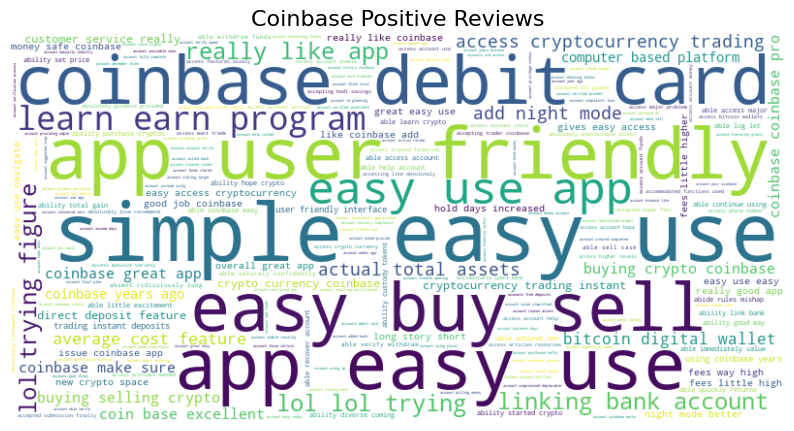

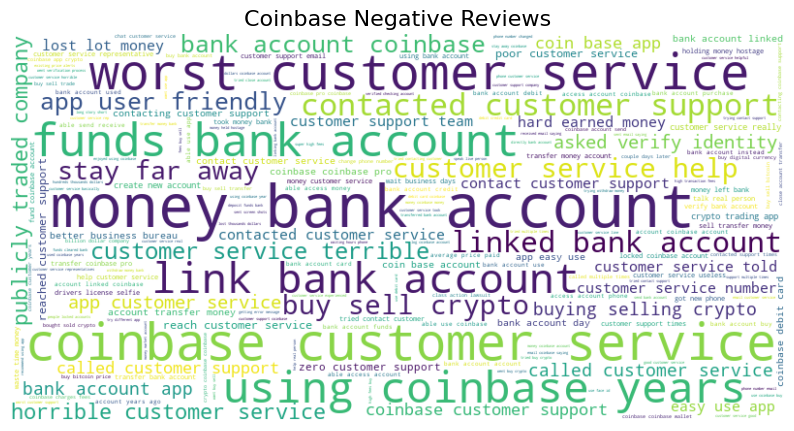

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

positive_reviews = coinbase_df[coinbase_df["vader_sentiment"] == "positive"]["review"]
negative_reviews = coinbase_df[coinbase_df["vader_sentiment"] == "negative"]["review"]

# Function to create trigram frequency dictionary
def get_trigram_freq(text_series):
    vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')
    X = vectorizer.fit_transform(text_series)
    freqs = X.toarray().sum(axis=0)
    trigram_freq = dict(zip(vectorizer.get_feature_names_out(), freqs))
    return trigram_freq

# Get trigram frequencies
positive_trigrams = get_trigram_freq(positive_reviews)
negative_trigrams = get_trigram_freq(negative_reviews)

# Plot function
def plot_trigram_wordcloud(trigram_freq, title):
    plt.figure(figsize=(10, 6))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(trigram_freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Plot trigram word clouds
plot_trigram_wordcloud(positive_trigrams, "Coinbase Positive Reviews")
plot_trigram_wordcloud(negative_trigrams, "Coinbase Negative Reviews")

## LDA using sklearn

In [16]:
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(neg_reviews['review'])

lda = LatentDirichletAllocation(n_components=4, random_state=42)
lda.fit(X)

# Top words per topic
for i, topic in enumerate(lda.components_):
    print(f"Topic {i+1}:")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])

Topic 1:
['fees', 'time', 'customer', 'bank', 'support', 'crypto', 'money', 'app', 'coinbase', 'account']
Topic 2:
['jacob', 'texted', 'phantom', 'armstrong', 'blocks', 'brian', 'excites', 'temp', 'sales', 'felt']
Topic 3:
['bnt', 'adjust', 'homepage', 'quit', 'men', 'jeremy', 'coordinated', 'renner', 'battery', 'bonus']
Topic 4:
['tolerated', 'angela', 'wi', 'bless', 'brian', 'fungible', 'passcode', 'wannabe', 'sendable', 'barcodes']


### Insights from topics 1 & 2
1. customer support (also phone, email, number, access) --> complaints about not reaching customer support --> improve customer support and communication
2. account, money --> frustration around accessing account/money --> streamline account recovery process
3. fees --> unclear or high fees --> improve fee transparency
4. time --> bad timing of transactions or delays --> improve reliabliity and speed of banking/crypto transfers

### Insights from topic 3: emotional cluster, likely angry reviews 
1. unimpressive, interfaces --> poor UI/UX --> simplify in-app navigation or run user/usability studies focusing on UI

### nothing useful from topic 4

# Sentiment Analysis (textblob)
### adds subjectivity, better for longer reviews

In [17]:
# !pip install textblob 
# nltk.download('punkt')

In [18]:
# from textblob import TextBlob
# '''
# polarity: [-1.0, 1.0]:
# - Negative = negative sentiment
# - Positive = positive sentiment
# - 0 = neutral
# subjectivity: 0.0, 1.0]:
# - Closer to 1 = opinion-based
# - Closer to 0 = more factual/objective
# '''
# def add_textblob_sentiment(df, text_col):
#     df[text_col] = df[text_col].astype(str)

#     # Apply TextBlob sentiment
#     df['textblob_polarity'] = df[text_col].apply(lambda x: TextBlob(x).sentiment.polarity)
#     df['textblob_subjectivity'] = df[text_col].apply(lambda x: TextBlob(x).sentiment.subjectivity)
    
#     return df

# coinbase_df_with_tb = add_textblob_sentiment(coinbase_df, 'review')
# coinbase_df_with_tb[['review', 'textblob_polarity', 'textblob_subjectivity']].head(10)

### not sure how to feel about text blob's polarity scores after cross referencing them with the original coinbase reviews and ratings

# text classificationmodel

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

## random forest

In [20]:
# 1. Vectorize text
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=5000)
X = vectorizer.fit_transform(coinbase_df["review"])
y = coinbase_df["rating"]

# 2. Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. random forest
mod = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=123)
mod.fit(X_train, y_train)
y_pred = mod.predict(X_test)

coinbase_df["ml_rating"] = mod.predict(vectorizer.transform(coinbase_df["review"]))

print(coinbase_df[["review", "rating", "ml_rating"]].head(15))

                                               review  rating  ml_rating
0   impressed easy app use endless amounts informa...       5          5
1   really good app crypto beginners intermediate ...       4          4
2   use coinbase three years happy service halfway...       1          1
3   absolutely mind boggling unhelpful circular cu...       1          1
4   left coinbase years ago kept removing payment ...       1          1
5   story goes like using coinbase everyday checki...       1          1
6   november th tried transfer btc another wallet ...       1          1
7   app simple investing recently decided get nfts...       1          1
8   first app used investing hopes customer servic...       1          1
9   coinbase loaded onto phone since early last we...       1          1
10  welcome new consumer savings account consumer ...       5          1
11  start saying since coinbase minimal issues giv...       3          3
12  several thousands xrp coins go missing coinbas.

In [21]:
# precision, recall, f1-score per class (1 / 2 / 3 / 4 / 5 star ratings)

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=mod.classes_)

for idx, label in enumerate(mod.classes_):
    print(f"Rating {label}:")
    print(f"  Precision: {precision[idx]:.2f}")
    print(f"  Recall:    {recall[idx]:.2f}")
    print(f"  F1-score:  {f1[idx]:.2f}")

Rating 1:
  Precision: 0.63
  Recall:    0.99
  F1-score:  0.77
Rating 2:
  Precision: 0.00
  Recall:    0.00
  F1-score:  0.00
Rating 3:
  Precision: 0.00
  Recall:    0.00
  F1-score:  0.00
Rating 4:
  Precision: 0.00
  Recall:    0.00
  F1-score:  0.00
Rating 5:
  Precision: 0.67
  Recall:    0.51
  F1-score:  0.58


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
coinbase_df["rating"].value_counts()

rating
1    533
5    242
2     83
3     77
4     65
Name: count, dtype: int64

In [23]:
coinbase_df['ml_rating'].value_counts()

ml_rating
1    590
5    228
2     66
3     60
4     56
Name: count, dtype: int64

## logreg attempt for better weighting

In [24]:
from sklearn.linear_model import LogisticRegression

# 1. Vectorize text
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X = vectorizer.fit_transform(coinbase_df["review"])
y = coinbase_df["rating"]

# 2. Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

#3. logreg
model = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    class_weight="balanced",  # Automatically balances classes
    max_iter=1000,
    random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, labels=model.classes_)

for idx, label in enumerate(model.classes_):
    print(f"Rating {label}:")
    print(f"  Precision: {precision[idx]:.2f}")
    print(f"  Recall:    {recall[idx]:.2f}")
    print(f"  F1-score:  {f1[idx]:.2f}")

Rating 1:
  Precision: 0.74
  Recall:    0.79
  F1-score:  0.76
Rating 2:
  Precision: 0.25
  Recall:    0.18
  F1-score:  0.21
Rating 3:
  Precision: 0.33
  Recall:    0.27
  F1-score:  0.30
Rating 4:
  Precision: 0.27
  Recall:    0.23
  F1-score:  0.25
Rating 5:
  Precision: 0.54
  Recall:    0.58
  F1-score:  0.56


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
